# Inspect the automatically generated training data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
import imgaug.augmenters as iaa
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Root directory of the project
ROOT_DIR = os.path.abspath("../training_data_generation/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import utils
import visualize
import config
from visualize import display_images
import model as modellib
from model import log
from train_model import ChemSegmentConfig, ChemPageDataset


%matplotlib inline 

## Configurations


In [2]:
# Defined in train_model.py
config = ChemSegmentConfig()

## Dataset

In [3]:
# Load dataset

dataset = ChemPageDataset()

# Must call before using the dataset
dataset.prepare()

## Display Samples

Load and display images and masks.

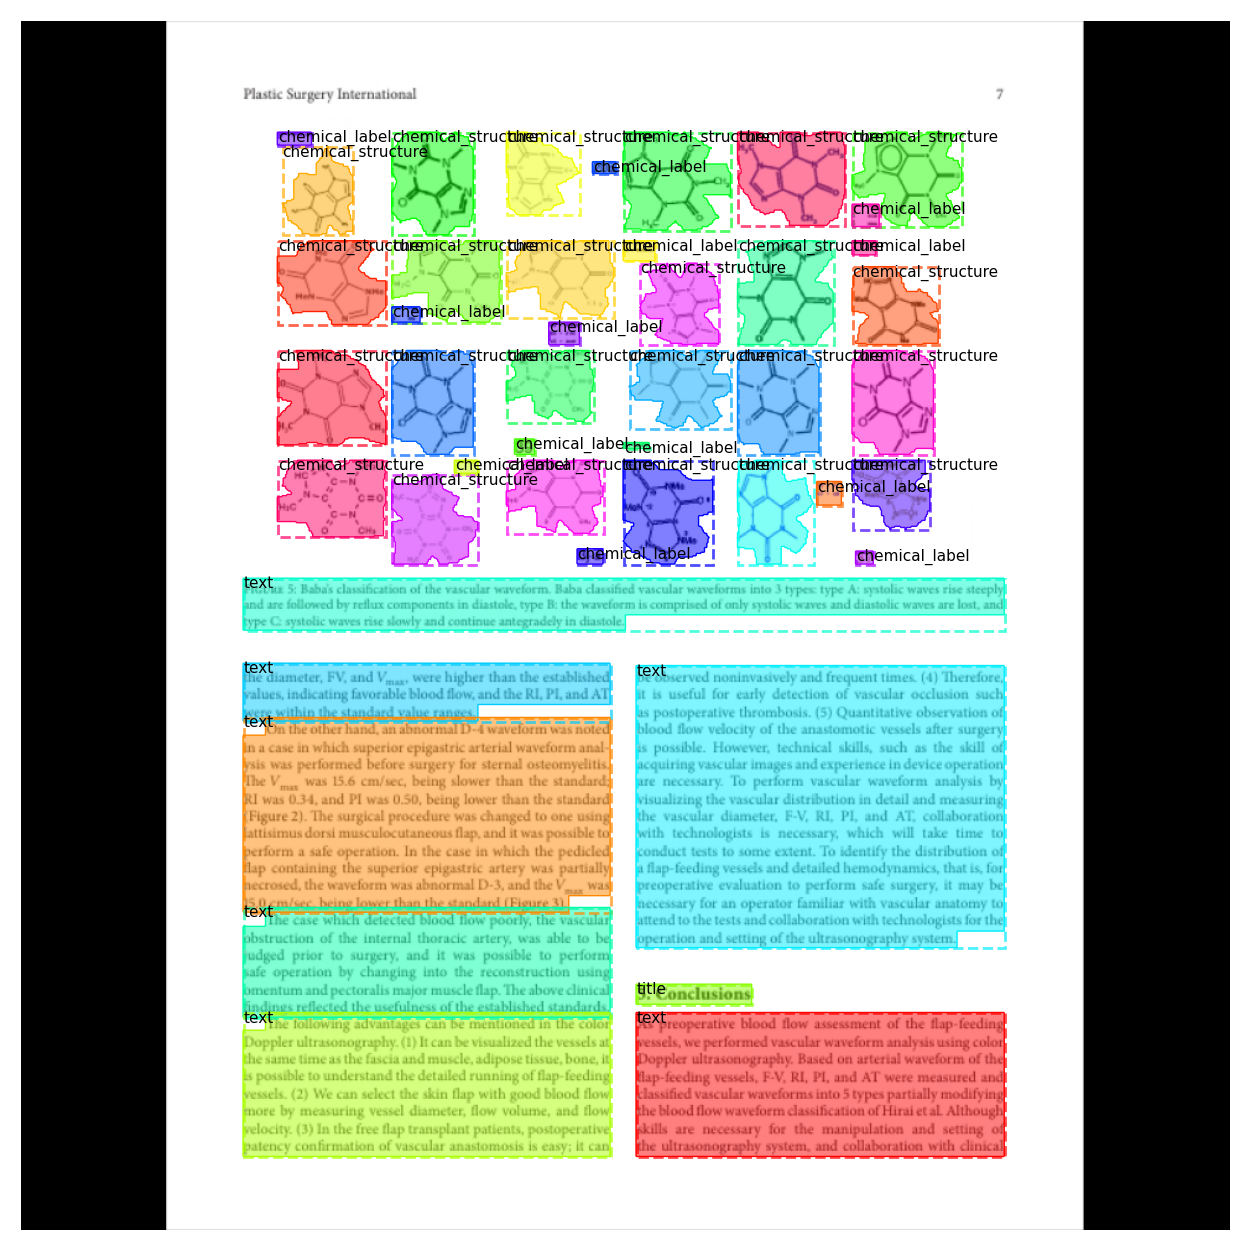


*** No instances to display *** 



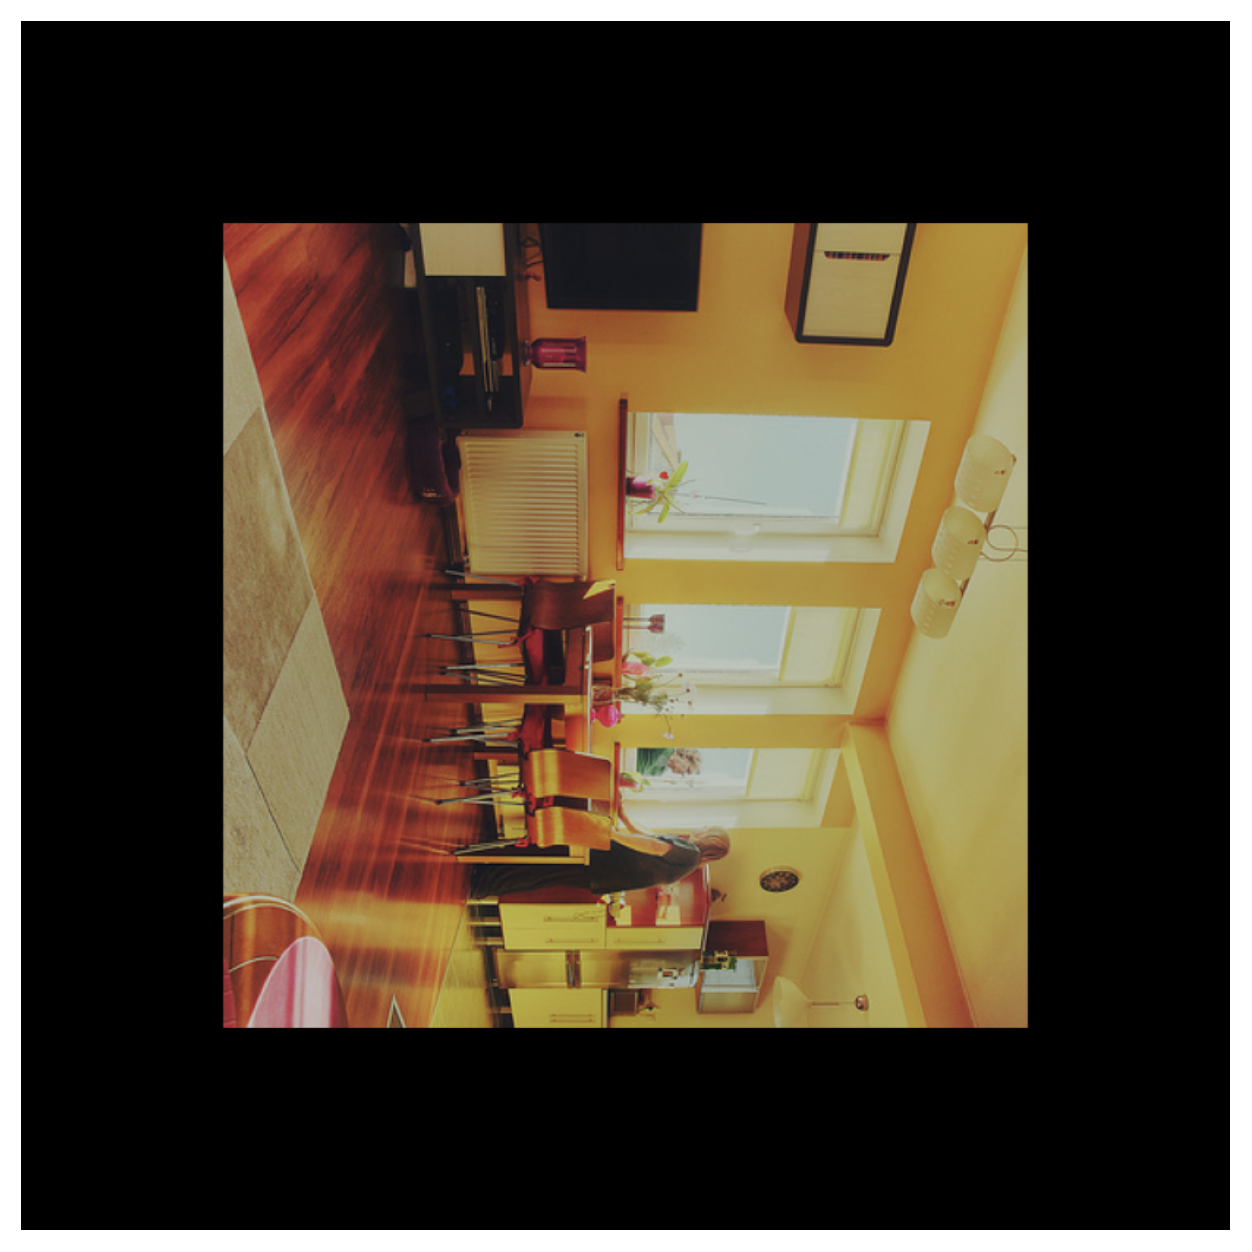


*** No instances to display *** 



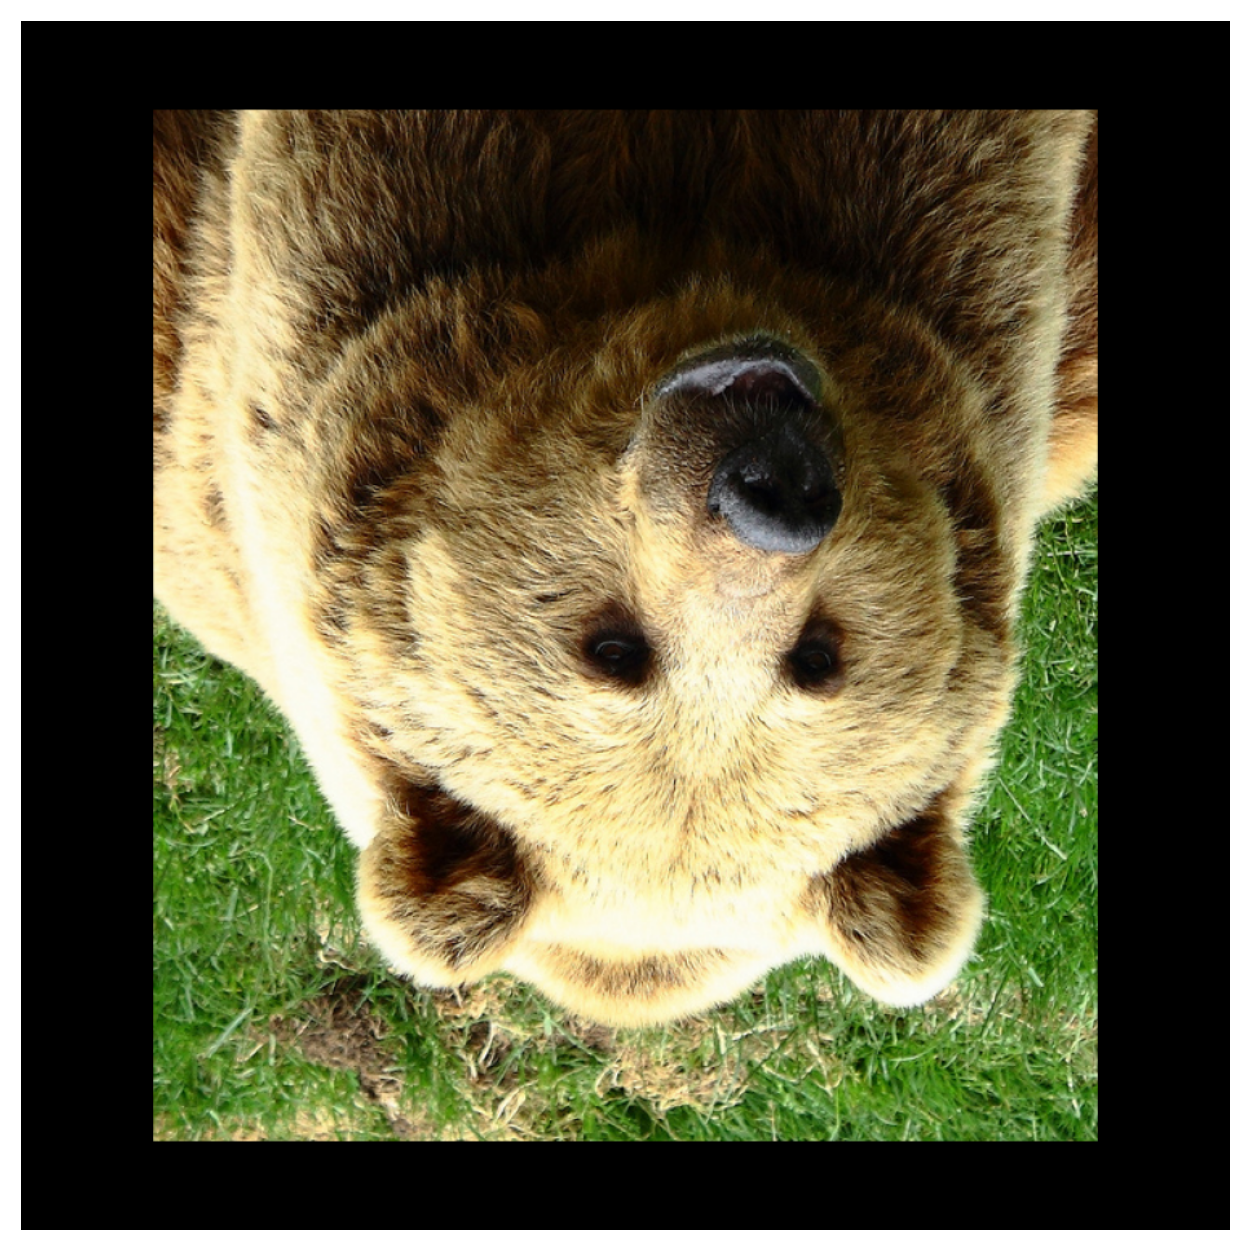

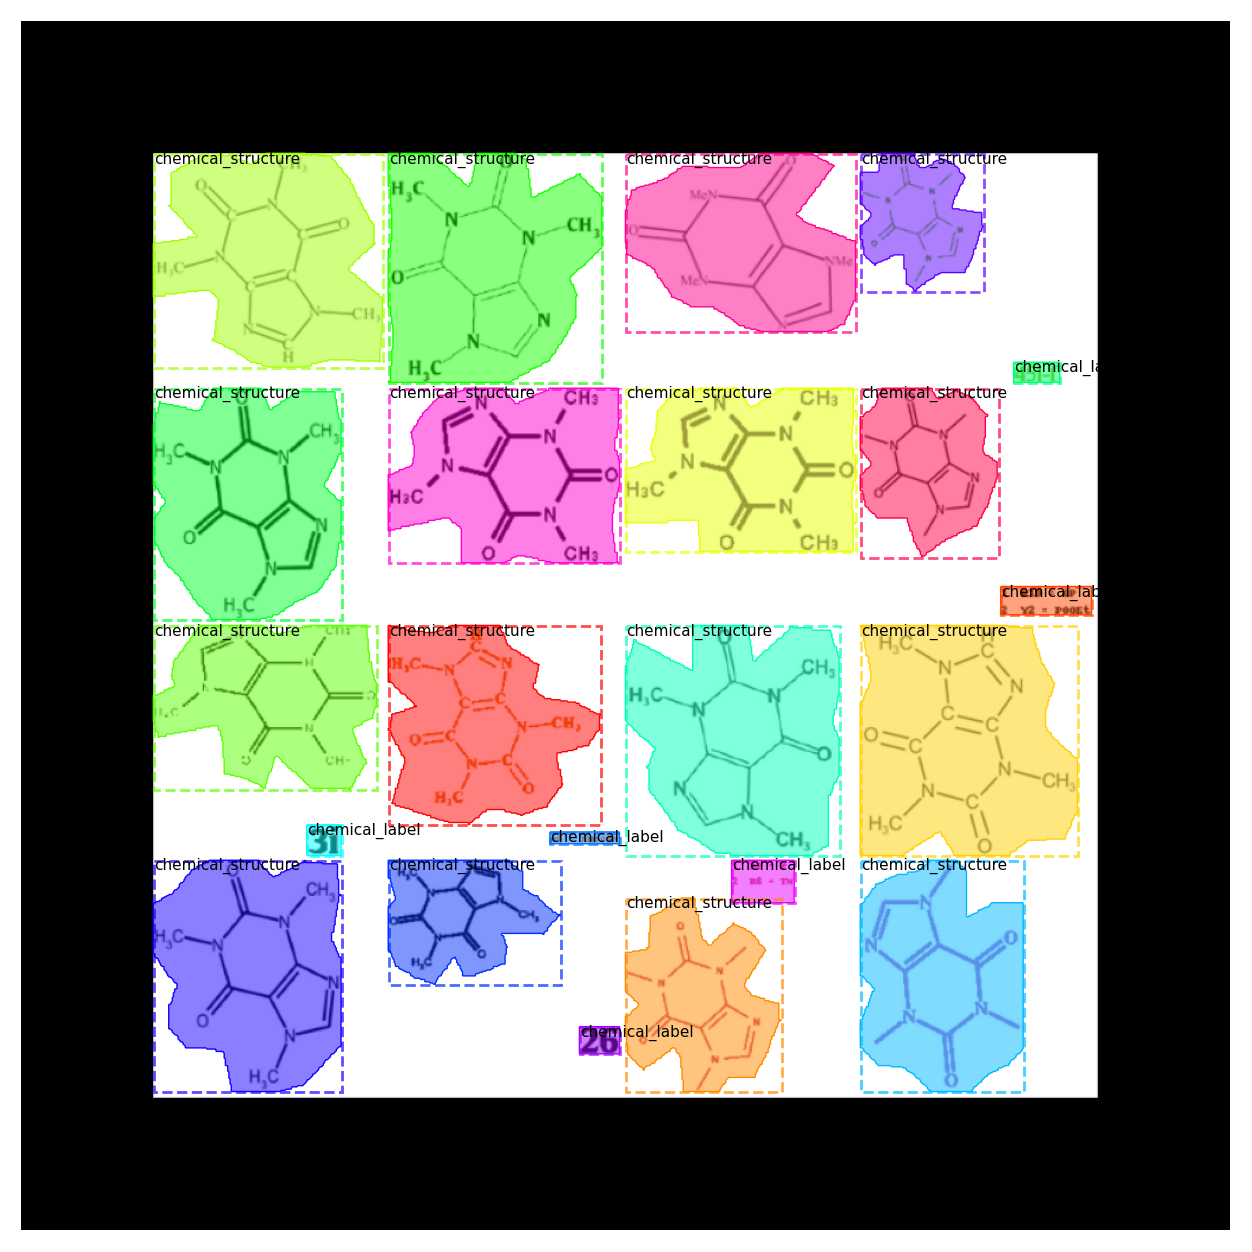

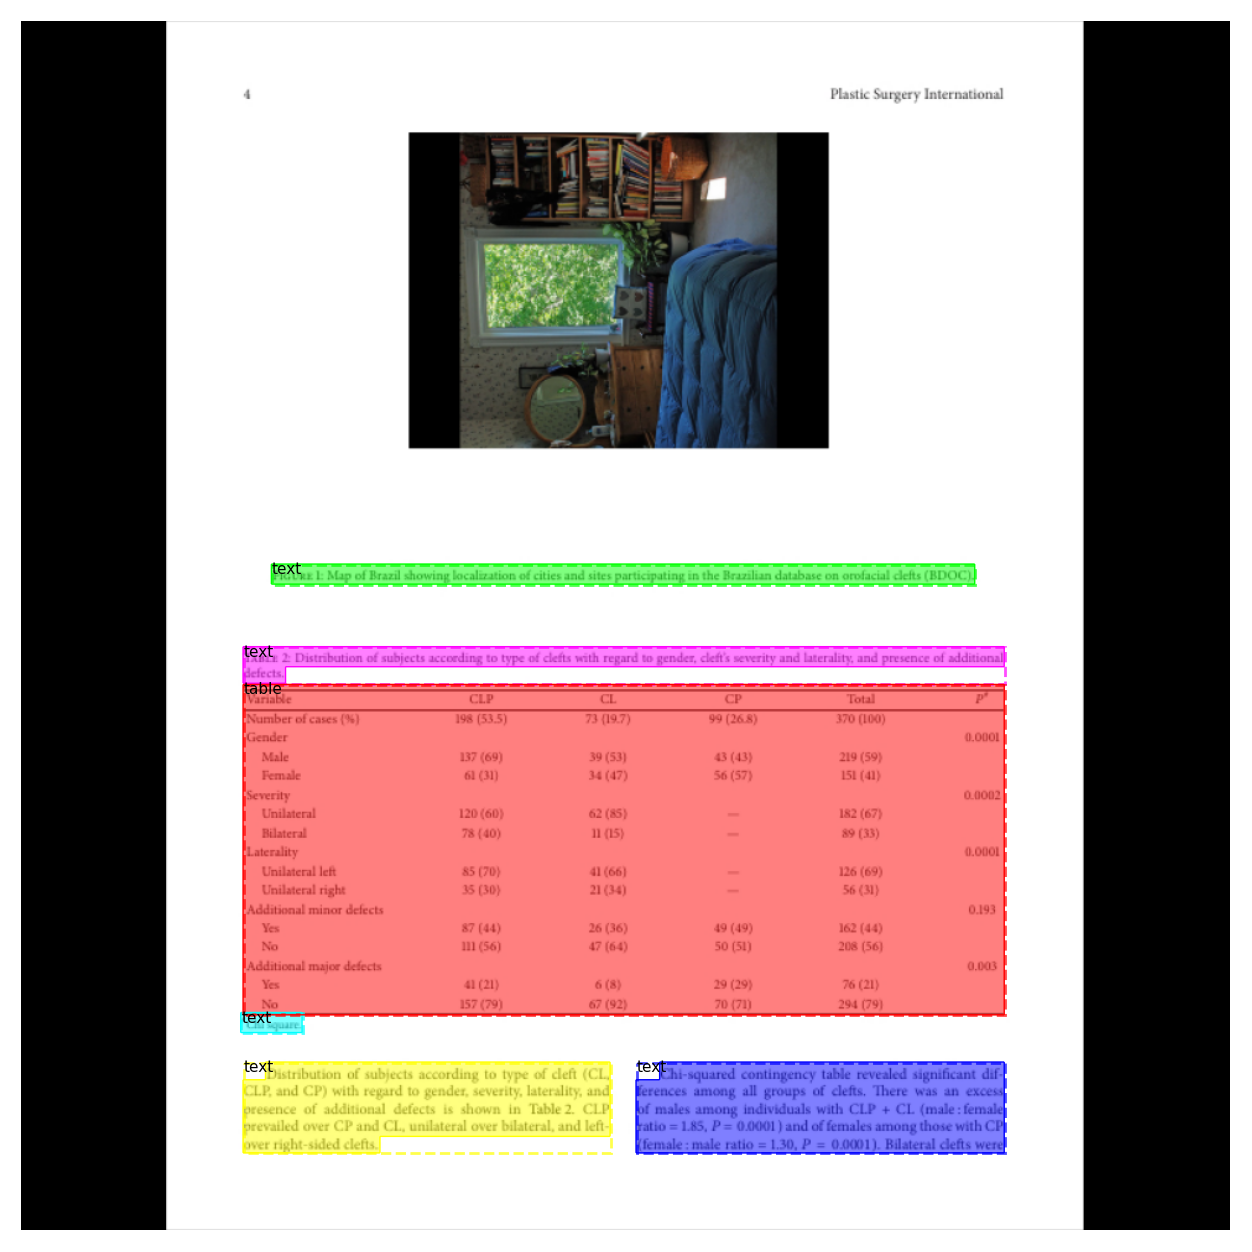

In [4]:
# Load and display random samples
for _ in range(5):
    image, _, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, 1)
    visualize.display_instances(image, bbox, mask, class_ids, dataset.categories)


## Image augmentation

You might want to apply image augmentation during training. It is highly recommended to check the effects of the different augmentation methods before applying them.

In [8]:
# Define image augmentation method that you want to apply
# Examples that usually work well:
augmentation = iaa.Sometimes(0.9,
    iaa.SomeOf((1,4), [
    iaa.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)}),
    iaa.Flipud(1),
    iaa.Fliplr(1),
    iaa.OneOf([iaa.GaussianBlur(sigma=(0.0, 2.0)),
               iaa.imgcorruptlike.JpegCompression(severity=(1,2)),
               iaa.imgcorruptlike.Pixelate(severity=(1,2))]),
    iaa.GammaContrast((2.0, 5.0)),
    iaa.ChangeColorTemperature((1100, 10000))
    ]))

# Example for an augmentation method that usually leads to problems:
#augmentation = iaa.RandAugment(m=30)

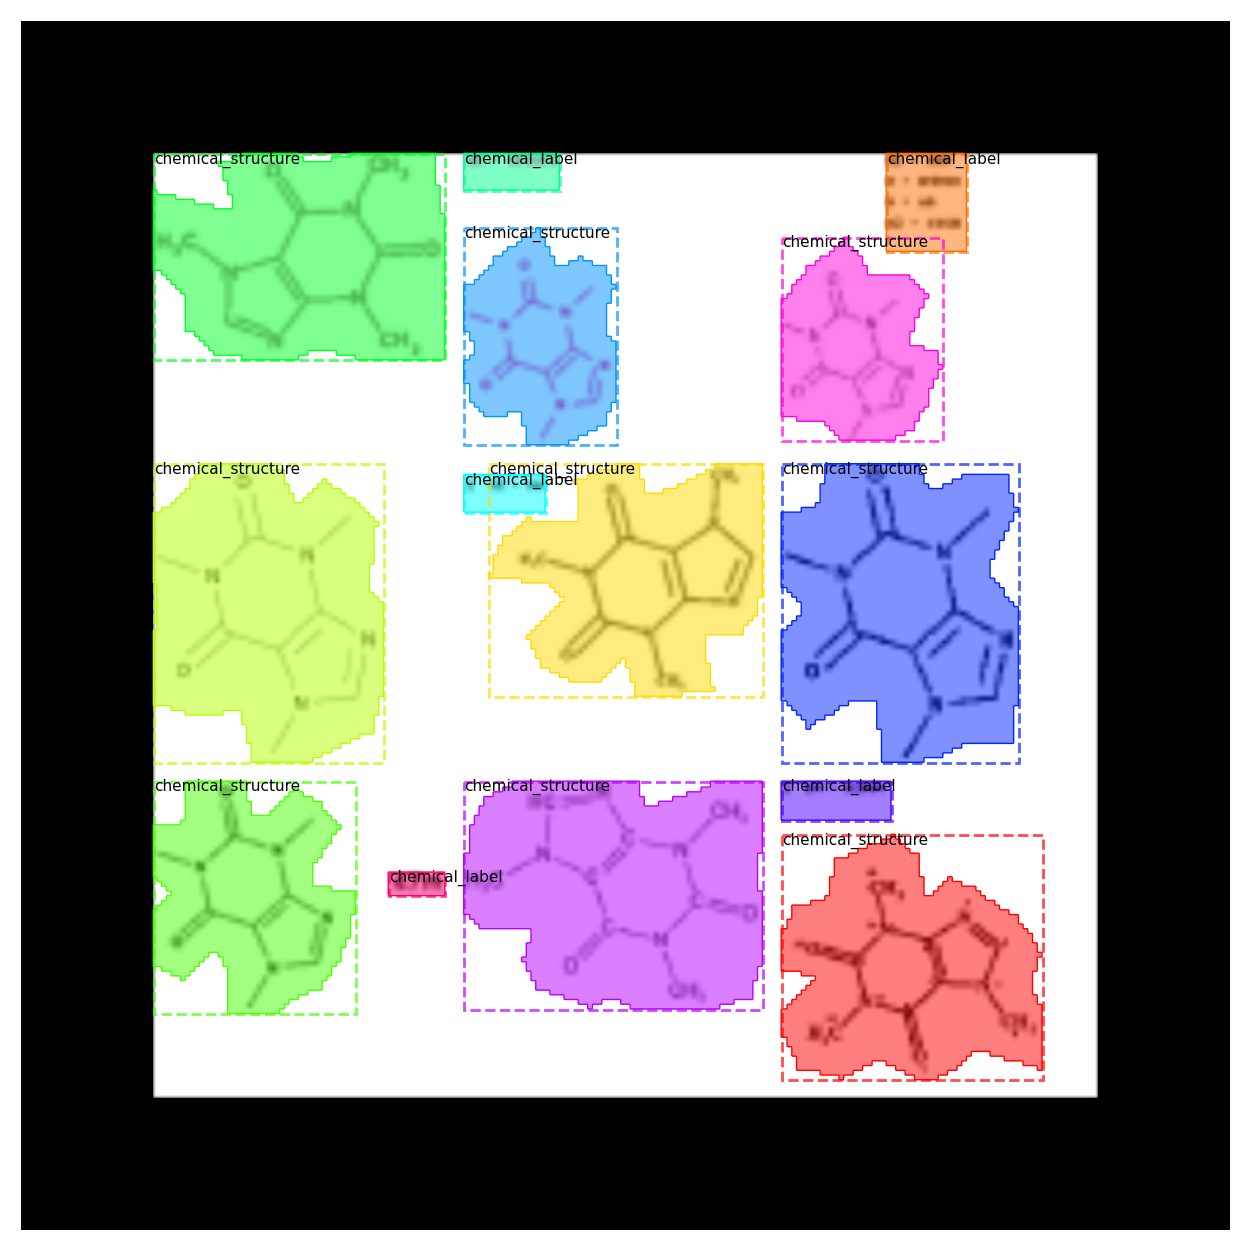

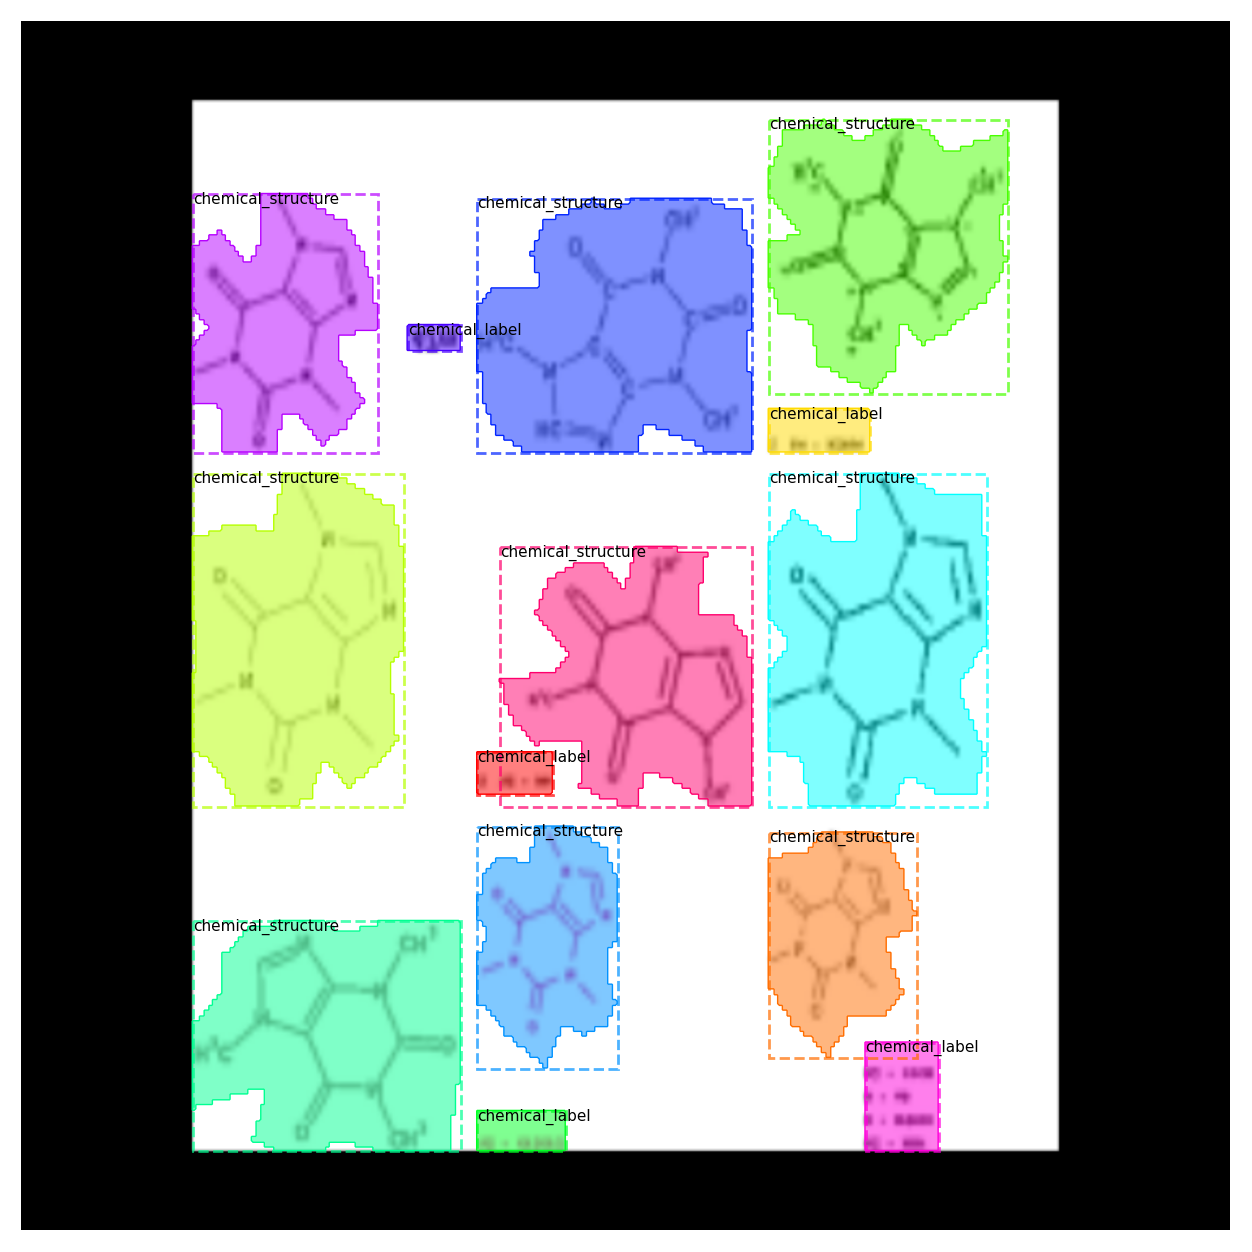

In [12]:
# The code here is mainly copied from load_model_gt() in model.py.

# Load random image and mask.
original_image, _, class_ids, bbox, original_mask = modellib.load_image_gt(dataset, config, 1)

# Store shapes before augmentation to compare
original_image_shape = original_image.shape
original_mask_shape = original_mask.shape

# Compute Bounding box
original_bbox = utils.extract_bboxes(original_mask)

# Apply augmentation
MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                           "Fliplr", "Flipud", "CropAndPad",
                           "Affine", "PiecewiseAffine"]

def hook(images, augmenter, parents, default):
    """Determines which augmenters to apply to masks."""
    return augmenter.__class__.__name__ in MASK_AUGMENTERS

# Make augmenters deterministic to apply similarly to images and masks
det = augmentation.to_deterministic()
augmented_image = det.augment_image(original_image)
# Change mask to np.uint8 because imgaug doesn't support np.bool
augmented_mask = det.augment_image(original_mask.astype(np.uint8),
                         hooks=imgaug.HooksImages(activator=hook))
# Compute Bounding box after augmentation
augmented_bbox = utils.extract_bboxes(augmented_mask)

# Verify that shapes didn't change
assert augmented_image.shape == original_image_shape, "Augmentation shouldn't change image size"
assert augmented_mask.shape == original_mask_shape, "Augmentation shouldn't change mask size"
# Change mask back to bool
#mask = mask.astype(np.bool)


# Display image and instances before and after image augmentation
visualize.display_instances(original_image, original_bbox, original_mask, class_ids, dataset.categories)
visualize.display_instances(augmented_image, augmented_bbox, augmented_mask, class_ids, dataset.categories)